In [1]:

import torch, random
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from pathlib import Path
import numpy as np
# ---------
# torch.set_grad_enabled(False)
# ============================
#       Radom Seed
# ============================
seed = 99

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.benchmark = True

if torch.cuda.is_available():
    print(f"cuda:True")
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")
else:
    print(f"cuda:False")
    device = torch.device("cpu")


# ============================
#       Equilibrium CNN
# ============================
def hardsigm(x):
    # return F.hardsigmoid(x)
    return x.clamp(min = 0, max=1)
def hardsigm_d(x):
        return (x >= 0) & (x <= 1)


cuda:True
GPU 0:NVIDIA RTX A5000:23.99GB


In [ ]:

class BP_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.chl = [32, 64]
        self.F = hardsigm #relu
        self.Fd = hardsigm_d # relu_d
        # Feedforward layers
        self.conv1 = nn.Conv2d(1, self.chl[0], kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(self.chl[0], self.chl[1], kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(self.chl[1] * 4 * 4, 10)

        self.deconv2 = nn.ConvTranspose2d(self.chl[1], self.chl[0], kernel_size=5, stride=1, padding=0)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x1 = self.F(self.conv1(x))               # (B, 32, 24, 24)
        x2, in1 = F.max_pool2d(x1, 2, return_indices=True)                 # (B, 32, 12, 12)
        x3 = self.F(self.conv2(x2))              # (B, 64, 8, 8)
        x4, in2 = F.max_pool2d(x3, 2, return_indices=True)                 # (B, 64, 4, 4)
        x_flat = x4.view(x4.size(0), -1)         # Flatten
        h1 = (self.fc1(x_flat))            # (B, 1024)
        return h1, (x1, x2, x3, x4, x_flat, in1, in2)

    def manual_backward(self, x, y):
        """
        Compute manual gradients and store in .grad attributes.
        After calling this, use an optimizer:
            optimizer.zero_grad()
            loss = model.manual_backward(x, y)
            optimizer.step()
        """
        x = x.to(self.device)
        y = y.to(self.device)
        batch_size = x.size(0)

        # Forward
        
        self.deconv2.weight.data = self.conv2.weight.data.clone()
        y_logits, (x1, x2, x3, x4, x_flat, in1, in2) = self.forward(x)
        y_prob = F.softmax(y_logits, dim=1)
        y_onehot = F.one_hot(y, num_classes=10).float().to(self.device)

        # Loss
        loss = F.cross_entropy(y_logits, y)

        # Clear previous grads
        self.zero_grad()

        # Gradient at output
        delta_out = (y_prob - y_onehot) / batch_size  # (B, 10) 

        # Gradients for fc1
        grad_fc1_w = delta_out.T @ x_flat
        grad_fc1_b = delta_out.sum(0)

        # Backprop into x4
        delta_x_flat = delta_out @ self.fc1.weight     # (B, 124)
        delta_x4 = delta_x_flat.view_as(x4)

        # Backprop through pooling & conv2
        # up_x4 = F.interpolate(delta_x4, scale_factor=2, mode='nearest')
        up_x4 = F.max_unpool2d(delta_x4, in2, kernel_size=2, stride = 2)

        delta_conv2_in = up_x4 *  self.Fd(x3)
        grad_conv2_w = torch.nn.grad.conv2d_weight(x2, self.conv2.weight.shape, delta_conv2_in,
                                                  stride=1, padding=0)
        grad_conv2_b = delta_conv2_in.sum(dim=(0, 2, 3)) #/ batch_size

        # Backprop through pooling & conv1
        delta_x2_from_conv2 = F.conv_transpose2d(
            delta_conv2_in,                     # the error after conv2 & its tanh'
            self.conv2.weight,                # your deconv2 weights
            stride=1, padding=0
        )

        # 2) unpool that back up to the size of x1
        # up_x2 = F.interpolate(delta_x2_from_conv2, scale_factor=2, mode='nearest')
        up_x2 = F.max_unpool2d(delta_x2_from_conv2, in1, kernel_size=2, stride = 2)

        # 3) apply tanh′ at x1
        delta_conv1_in = up_x2 * self.Fd(x1)

        # 4) now compute grads for conv1
        grad_conv1_w = torch.nn.grad.conv2d_weight(
            x,                                   # original input to conv1
            self.conv1.weight.shape,
            delta_conv1_in,
            stride=1, padding=0
        )
        grad_conv1_b = delta_conv1_in.sum(dim=(0,2,3)) #/ batch_size

        # Assign to .grad for optimizer
        self.fc1.weight.grad = grad_fc1_w 
        self.fc1.bias.grad   = grad_fc1_b 
        self.conv2.weight.grad = grad_conv2_w     
        self.conv2.bias.grad   = grad_conv2_b     
        self.conv1.weight.grad = grad_conv1_w     
        self.conv1.bias.grad   = grad_conv1_b     

        return y_logits.argmax(dim=1),loss.item()

    
    def predict(self, x):
        with torch.no_grad():
            x = x.to(self.device)
            # self.deconv2.weight.data = self.conv2.weight.data.clone()
            y_logits, _ = self.forward(x)
            return y_logits.argmax(dim=1)

In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_subset = Subset(train_set, range(int(1 * len(train_set))))
test_subset = Subset(test_set, range(int(1 * len(test_set))))

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=500, shuffle=False)

print(torch.cuda.is_available())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        device = torch.device(f"cuda:{i}")
        properties = torch.cuda.get_device_properties(device)
        print(f"GPU {i}:{properties.name}:{properties.total_memory/1024/1024/1024:.2f}GB")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader_gpu = [(data.to(device), target.to(device)) for data, target in train_loader]
test_loader_gpu = [(data.to(device), target.to(device)) for data, target in test_loader]
current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(f"{0} start at {current_time_tmp}")

True
GPU 0:NVIDIA RTX A5000:23.99GB
0 start at 20250720-184234


In [ ]:
fsave=True
current_time_start = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_path = Path(f"./Res/Final_BP_conv_{current_time_start}-MNSIT")
res_path.mkdir(parents=True, exist_ok=True)
num_epochs = 40
multest =5
res = np.zeros((multest,3,num_epochs))

for imul in range(multest):
    current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(f"{imul} start at {current_time_tmp}")
    model = BP_CNN()
   
    lr = [0.001, 0.02, 0.4] # 
    wd = [1e-5, 1e-5, 1e-5] #
    optimizer = torch.optim.SGD([
            {'params': model.conv1.parameters(), 'lr': lr[0], 'weight_decay': wd[0]},  # conv1 
            {'params': model.conv2.parameters(), 'lr': lr[1], 'weight_decay': wd[1]},  # conv2 
            {'params': model.fc1.parameters(), 'lr': lr[2], 'weight_decay': wd[2]},  # conv2 
        ])


    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        # model.train()
        random.shuffle(train_loader_gpu)
        with tqdm(total=len(train_loader_gpu), desc=f"Epoch {epoch + 1}/{num_epochs}:", unit='batch', ncols=90, mininterval=1, colour='blue') as pbar:
            for batch_idx, (data, target) in enumerate(train_loader_gpu):
                optimizer.zero_grad()
                preds, loss = model.manual_backward(data, target)
                optimizer.step()
                total_loss += loss

                correct += (preds == target).sum().item()
                total += target.size(0)
                if batch_idx % 10 == 0: 
                    pbar.set_postfix({'loss': f'{total_loss/(batch_idx+1):.6f}'})  
                    pbar.update(10)

        acc = correct / total
        avg_loss = total_loss / len(train_loader_gpu)
        res[imul,0,epoch]=(avg_loss)
        res[imul,1,epoch]=(acc)
        # Test
        # model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader_gpu:
                preds = model.predict(data)
                correct += (preds == target).sum().item()
                total += target.size(0)
        test_acc = correct / total
        res[imul,2,epoch]=(test_acc)
        print(f"Epoch {epoch+1} Train Loss = {avg_loss:.4f}, Accuracy = {acc*100:.2f}%, Test Accuracy = {test_acc*100:.2f}%")
        
    current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    print(f"{imul} end at {current_time_tmp}")

0 start at 20250720-184234


Epoch 1/40:: 470batch [00:03, 141.57batch/s, loss=0.371209]                               0.371209]


Epoch 1 Train Loss = 0.3674, Accuracy = 89.66%, Test Accuracy = 95.79%


Epoch 2/40:: 470batch [00:01, 294.29batch/s, loss=0.138804]                               0.138804]


Epoch 2 Train Loss = 0.1385, Accuracy = 96.04%, Test Accuracy = 96.70%


Epoch 3/40:: 470batch [00:01, 280.12batch/s, loss=0.106976]                               0.106976]


Epoch 3 Train Loss = 0.1071, Accuracy = 96.94%, Test Accuracy = 97.64%


Epoch 4/40:: 470batch [00:01, 284.86batch/s, loss=0.090661]                               0.090661]


Epoch 4 Train Loss = 0.0906, Accuracy = 97.41%, Test Accuracy = 97.83%


Epoch 5/40:: 470batch [00:01, 341.34batch/s, loss=0.079304]                               0.079304]


Epoch 5 Train Loss = 0.0796, Accuracy = 97.69%, Test Accuracy = 98.13%


Epoch 6/40:: 470batch [00:01, 298.34batch/s, loss=0.071584]                               0.071584]


Epoch 6 Train Loss = 0.0718, Accuracy = 97.96%, Test Accuracy = 98.23%


Epoch 7/40:: 470batch [00:01, 314.66batch/s, loss=0.066647]                               0.066647]


Epoch 7 Train Loss = 0.0664, Accuracy = 98.08%, Test Accuracy = 98.27%


Epoch 8/40:: 470batch [00:01, 319.11batch/s, loss=0.061723]                               0.061723]


Epoch 8 Train Loss = 0.0618, Accuracy = 98.23%, Test Accuracy = 98.42%


Epoch 9/40:: 470batch [00:01, 322.40batch/s, loss=0.058832]                               0.058832]


Epoch 9 Train Loss = 0.0585, Accuracy = 98.30%, Test Accuracy = 98.06%


Epoch 10/40:: 470batch [00:01, 287.77batch/s, loss=0.055377]                              0.055377]


Epoch 10 Train Loss = 0.0552, Accuracy = 98.40%, Test Accuracy = 98.47%


Epoch 11/40:: 470batch [00:01, 285.01batch/s, loss=0.053361]                              0.053361]


Epoch 11 Train Loss = 0.0532, Accuracy = 98.41%, Test Accuracy = 98.58%


Epoch 12/40:: 470batch [00:01, 300.37batch/s, loss=0.050801]                              0.050801]


Epoch 12 Train Loss = 0.0509, Accuracy = 98.51%, Test Accuracy = 98.60%


Epoch 13/40:: 470batch [00:01, 297.06batch/s, loss=0.048735]                              0.048735]


Epoch 13 Train Loss = 0.0487, Accuracy = 98.55%, Test Accuracy = 98.52%


Epoch 14/40:: 470batch [00:01, 276.59batch/s, loss=0.046769]                              0.046769]


Epoch 14 Train Loss = 0.0467, Accuracy = 98.63%, Test Accuracy = 98.51%


Epoch 15/40:: 470batch [00:01, 264.93batch/s, loss=0.045327]                              0.045327]


Epoch 15 Train Loss = 0.0455, Accuracy = 98.68%, Test Accuracy = 98.59%


Epoch 16/40:: 470batch [00:01, 273.91batch/s, loss=0.044293]                              0.044293]


Epoch 16 Train Loss = 0.0442, Accuracy = 98.69%, Test Accuracy = 98.59%


Epoch 17/40:: 470batch [00:01, 280.35batch/s, loss=0.042663]                              0.042663]


Epoch 17 Train Loss = 0.0428, Accuracy = 98.71%, Test Accuracy = 98.55%


Epoch 18/40:: 470batch [00:01, 294.87batch/s, loss=0.041662]                              0.041662]


Epoch 18 Train Loss = 0.0418, Accuracy = 98.75%, Test Accuracy = 98.54%


Epoch 19/40:: 470batch [00:01, 281.11batch/s, loss=0.040867]                              0.040867]


Epoch 19 Train Loss = 0.0409, Accuracy = 98.80%, Test Accuracy = 98.57%


Epoch 20/40:: 470batch [00:01, 298.51batch/s, loss=0.039876]                              0.039876]


Epoch 20 Train Loss = 0.0398, Accuracy = 98.78%, Test Accuracy = 98.65%


Epoch 21/40:: 470batch [00:01, 305.52batch/s, loss=0.039278]                              0.039278]


Epoch 21 Train Loss = 0.0392, Accuracy = 98.86%, Test Accuracy = 98.57%


Epoch 22/40:: 470batch [00:01, 301.12batch/s, loss=0.037896]                              0.037896]


Epoch 22 Train Loss = 0.0380, Accuracy = 98.90%, Test Accuracy = 98.43%


Epoch 23/40:: 470batch [00:01, 279.79batch/s, loss=0.038088]                              0.038088]


Epoch 23 Train Loss = 0.0378, Accuracy = 98.89%, Test Accuracy = 98.63%


Epoch 24/40:: 470batch [00:01, 288.13batch/s, loss=0.037155]                              0.037155]


Epoch 24 Train Loss = 0.0369, Accuracy = 98.91%, Test Accuracy = 98.38%


Epoch 25/40:: 470batch [00:01, 317.05batch/s, loss=0.036242]                              0.036242]


Epoch 25 Train Loss = 0.0363, Accuracy = 98.95%, Test Accuracy = 98.64%


Epoch 26/40:: 470batch [00:01, 334.76batch/s, loss=0.035912]                              0.035912]


Epoch 26 Train Loss = 0.0358, Accuracy = 98.99%, Test Accuracy = 98.57%


Epoch 27/40:: 470batch [00:01, 322.27batch/s, loss=0.035269]                              0.035269]


Epoch 27 Train Loss = 0.0351, Accuracy = 98.98%, Test Accuracy = 98.63%


Epoch 28/40:: 470batch [00:01, 332.22batch/s, loss=0.034408]                              0.034408]


Epoch 28 Train Loss = 0.0343, Accuracy = 99.00%, Test Accuracy = 98.67%


Epoch 29/40:: 470batch [00:01, 313.31batch/s, loss=0.034275]                              0.034275]


Epoch 29 Train Loss = 0.0342, Accuracy = 98.99%, Test Accuracy = 98.58%


Epoch 30/40:: 470batch [00:01, 339.87batch/s, loss=0.033566]                              0.033566]


Epoch 30 Train Loss = 0.0337, Accuracy = 99.05%, Test Accuracy = 98.61%


Epoch 31/40:: 470batch [00:01, 308.46batch/s, loss=0.033080]                              0.033080]


Epoch 31 Train Loss = 0.0331, Accuracy = 99.05%, Test Accuracy = 98.77%


Epoch 32/40:: 470batch [00:01, 318.05batch/s, loss=0.033138]                              0.033138]


Epoch 32 Train Loss = 0.0331, Accuracy = 99.04%, Test Accuracy = 98.67%


Epoch 33/40:: 470batch [00:01, 330.06batch/s, loss=0.032525]                              0.032525]


Epoch 33 Train Loss = 0.0326, Accuracy = 99.02%, Test Accuracy = 98.57%


Epoch 34/40:: 470batch [00:01, 308.50batch/s, loss=0.032302]                              0.032302]


Epoch 34 Train Loss = 0.0322, Accuracy = 99.07%, Test Accuracy = 98.61%


Epoch 35/40:: 470batch [00:01, 320.78batch/s, loss=0.031767]                              0.031767]


Epoch 35 Train Loss = 0.0317, Accuracy = 99.07%, Test Accuracy = 98.46%


Epoch 36/40:: 470batch [00:01, 321.37batch/s, loss=0.031530]                              0.031530]


Epoch 36 Train Loss = 0.0315, Accuracy = 99.10%, Test Accuracy = 98.62%


Epoch 37/40:: 470batch [00:01, 325.14batch/s, loss=0.031379]                              0.031379]


Epoch 37 Train Loss = 0.0315, Accuracy = 99.11%, Test Accuracy = 98.64%


Epoch 38/40:: 470batch [00:01, 333.72batch/s, loss=0.030811]                              0.030811]


Epoch 38 Train Loss = 0.0310, Accuracy = 99.11%, Test Accuracy = 98.41%


Epoch 39/40:: 470batch [00:01, 314.01batch/s, loss=0.030795]                              0.030795]


Epoch 39 Train Loss = 0.0311, Accuracy = 99.10%, Test Accuracy = 98.37%


Epoch 40/40:: 470batch [00:01, 310.97batch/s, loss=0.031091]                              0.031091]


Epoch 40 Train Loss = 0.0309, Accuracy = 99.10%, Test Accuracy = 98.50%
0 end at 20250720-184339
1 start at 20250720-184339


Epoch 1/40:: 470batch [00:01, 302.98batch/s, loss=0.369335]                               0.369335]


Epoch 1 Train Loss = 0.3661, Accuracy = 90.22%, Test Accuracy = 96.31%


Epoch 2/40:: 470batch [00:01, 316.14batch/s, loss=0.124544]                               0.124544]


Epoch 2 Train Loss = 0.1246, Accuracy = 96.51%, Test Accuracy = 97.42%


Epoch 3/40:: 470batch [00:01, 310.64batch/s, loss=0.094740]                               0.094740]


Epoch 3 Train Loss = 0.0940, Accuracy = 97.33%, Test Accuracy = 97.96%


Epoch 4/40:: 470batch [00:01, 307.62batch/s, loss=0.078834]                               0.078834]


Epoch 4 Train Loss = 0.0789, Accuracy = 97.72%, Test Accuracy = 98.09%


Epoch 5/40:: 470batch [00:01, 339.62batch/s, loss=0.069210]                               0.069210]


Epoch 5 Train Loss = 0.0689, Accuracy = 98.01%, Test Accuracy = 98.50%


Epoch 6/40:: 470batch [00:01, 337.57batch/s, loss=0.062153]                               0.062153]


Epoch 6 Train Loss = 0.0622, Accuracy = 98.23%, Test Accuracy = 98.45%


Epoch 7/40:: 470batch [00:01, 319.20batch/s, loss=0.056657]                               0.056657]


Epoch 7 Train Loss = 0.0567, Accuracy = 98.36%, Test Accuracy = 98.63%


Epoch 8/40:: 470batch [00:01, 328.40batch/s, loss=0.052963]                               0.052963]


Epoch 8 Train Loss = 0.0528, Accuracy = 98.47%, Test Accuracy = 98.56%


Epoch 9/40:: 470batch [00:01, 326.59batch/s, loss=0.049645]                               0.049645]


Epoch 9 Train Loss = 0.0497, Accuracy = 98.53%, Test Accuracy = 98.66%


Epoch 10/40:: 470batch [00:01, 325.58batch/s, loss=0.046721]                              0.046721]


Epoch 10 Train Loss = 0.0469, Accuracy = 98.62%, Test Accuracy = 98.71%


Epoch 11/40:: 470batch [00:01, 326.10batch/s, loss=0.044197]                              0.044197]


Epoch 11 Train Loss = 0.0441, Accuracy = 98.71%, Test Accuracy = 98.75%


Epoch 12/40:: 470batch [00:01, 318.06batch/s, loss=0.042046]                              0.042046]


Epoch 12 Train Loss = 0.0421, Accuracy = 98.79%, Test Accuracy = 98.63%


Epoch 13/40:: 470batch [00:01, 310.85batch/s, loss=0.040378]                              0.040378]


Epoch 13 Train Loss = 0.0403, Accuracy = 98.83%, Test Accuracy = 98.90%


Epoch 14/40:: 470batch [00:01, 322.71batch/s, loss=0.038659]                              0.038659]


Epoch 14 Train Loss = 0.0387, Accuracy = 98.92%, Test Accuracy = 98.83%


Epoch 15/40:: 470batch [00:01, 313.07batch/s, loss=0.037239]                              0.037239]


Epoch 15 Train Loss = 0.0371, Accuracy = 98.94%, Test Accuracy = 98.75%


Epoch 16/40:: 470batch [00:01, 314.01batch/s, loss=0.035856]                              0.035856]


Epoch 16 Train Loss = 0.0359, Accuracy = 98.96%, Test Accuracy = 98.77%


Epoch 17/40:: 470batch [00:01, 316.85batch/s, loss=0.034641]                              0.034641]


Epoch 17 Train Loss = 0.0346, Accuracy = 99.01%, Test Accuracy = 98.84%


Epoch 18/40:: 470batch [00:01, 288.69batch/s, loss=0.033332]                              0.033332]


Epoch 18 Train Loss = 0.0333, Accuracy = 99.04%, Test Accuracy = 98.92%


Epoch 19/40:: 470batch [00:01, 336.11batch/s, loss=0.032317]                              0.032317]


Epoch 19 Train Loss = 0.0323, Accuracy = 99.08%, Test Accuracy = 98.91%


Epoch 20/40:: 470batch [00:01, 317.01batch/s, loss=0.031482]                              0.031482]


Epoch 20 Train Loss = 0.0313, Accuracy = 99.12%, Test Accuracy = 99.00%


Epoch 21/40:: 470batch [00:01, 311.35batch/s, loss=0.030160]                              0.030160]


Epoch 21 Train Loss = 0.0302, Accuracy = 99.18%, Test Accuracy = 98.99%


Epoch 22/40:: 470batch [00:01, 312.09batch/s, loss=0.029404]                              0.029404]


Epoch 22 Train Loss = 0.0293, Accuracy = 99.16%, Test Accuracy = 98.87%


Epoch 23/40:: 470batch [00:01, 320.48batch/s, loss=0.028628]                              0.028628]


Epoch 23 Train Loss = 0.0285, Accuracy = 99.18%, Test Accuracy = 98.99%


Epoch 24/40:: 470batch [00:01, 327.81batch/s, loss=0.027709]                              0.027709]


Epoch 24 Train Loss = 0.0277, Accuracy = 99.24%, Test Accuracy = 98.99%


Epoch 25/40:: 470batch [00:01, 343.16batch/s, loss=0.026696]                              0.026696]


Epoch 25 Train Loss = 0.0267, Accuracy = 99.26%, Test Accuracy = 99.03%


Epoch 26/40:: 470batch [00:01, 317.61batch/s, loss=0.025863]                              0.025863]


Epoch 26 Train Loss = 0.0259, Accuracy = 99.29%, Test Accuracy = 98.95%


Epoch 27/40:: 470batch [00:01, 321.26batch/s, loss=0.025256]                              0.025256]


Epoch 27 Train Loss = 0.0254, Accuracy = 99.30%, Test Accuracy = 98.95%


Epoch 28/40:: 470batch [00:01, 307.17batch/s, loss=0.024658]                              0.024658]


Epoch 28 Train Loss = 0.0246, Accuracy = 99.31%, Test Accuracy = 98.98%


Epoch 29/40:: 470batch [00:01, 318.26batch/s, loss=0.024017]                              0.024017]


Epoch 29 Train Loss = 0.0241, Accuracy = 99.33%, Test Accuracy = 99.02%


Epoch 30/40:: 470batch [00:01, 305.53batch/s, loss=0.023190]                              0.023190]


Epoch 30 Train Loss = 0.0233, Accuracy = 99.38%, Test Accuracy = 99.05%


Epoch 31/40:: 470batch [00:01, 303.72batch/s, loss=0.023027]                              0.023027]


Epoch 31 Train Loss = 0.0229, Accuracy = 99.37%, Test Accuracy = 99.03%


Epoch 32/40:: 470batch [00:01, 325.08batch/s, loss=0.022189]                              0.022189]


Epoch 32 Train Loss = 0.0222, Accuracy = 99.42%, Test Accuracy = 98.94%


Epoch 33/40:: 470batch [00:01, 314.14batch/s, loss=0.021693]                              0.021693]


Epoch 33 Train Loss = 0.0216, Accuracy = 99.44%, Test Accuracy = 99.06%


Epoch 34/40:: 470batch [00:01, 327.35batch/s, loss=0.021410]                              0.021410]


Epoch 34 Train Loss = 0.0213, Accuracy = 99.43%, Test Accuracy = 98.98%


Epoch 35/40:: 470batch [00:01, 287.75batch/s, loss=0.020799]                              0.020799]


Epoch 35 Train Loss = 0.0207, Accuracy = 99.48%, Test Accuracy = 98.99%


Epoch 36/40:: 470batch [00:01, 303.39batch/s, loss=0.020274]                              0.020274]


Epoch 36 Train Loss = 0.0202, Accuracy = 99.48%, Test Accuracy = 99.10%


Epoch 37/40:: 470batch [00:01, 294.61batch/s, loss=0.019821]                              0.019821]


Epoch 37 Train Loss = 0.0198, Accuracy = 99.48%, Test Accuracy = 99.03%


Epoch 38/40:: 470batch [00:01, 287.86batch/s, loss=0.019460]                              0.019460]


Epoch 38 Train Loss = 0.0195, Accuracy = 99.50%, Test Accuracy = 99.04%


Epoch 39/40:: 470batch [00:01, 306.92batch/s, loss=0.019062]                              0.019062]


Epoch 39 Train Loss = 0.0191, Accuracy = 99.52%, Test Accuracy = 98.98%


Epoch 40/40:: 470batch [00:01, 346.78batch/s, loss=0.018737]                              0.018737]


Epoch 40 Train Loss = 0.0186, Accuracy = 99.52%, Test Accuracy = 99.08%
1 end at 20250720-184440
2 start at 20250720-184440


Epoch 1/40:: 470batch [00:01, 333.88batch/s, loss=0.343857]                               0.343857]


Epoch 1 Train Loss = 0.3406, Accuracy = 90.64%, Test Accuracy = 96.22%


Epoch 2/40:: 470batch [00:01, 336.40batch/s, loss=0.126843]                               0.126843]


Epoch 2 Train Loss = 0.1263, Accuracy = 96.41%, Test Accuracy = 97.41%


Epoch 3/40:: 470batch [00:01, 316.28batch/s, loss=0.096406]                               0.096406]


Epoch 3 Train Loss = 0.0961, Accuracy = 97.23%, Test Accuracy = 97.76%


Epoch 4/40:: 470batch [00:01, 284.25batch/s, loss=0.080260]                               0.080260]


Epoch 4 Train Loss = 0.0802, Accuracy = 97.72%, Test Accuracy = 98.09%


Epoch 5/40:: 470batch [00:01, 325.86batch/s, loss=0.069486]                               0.069486]


Epoch 5 Train Loss = 0.0697, Accuracy = 98.00%, Test Accuracy = 98.14%


Epoch 6/40:: 470batch [00:01, 320.86batch/s, loss=0.062730]                               0.062730]


Epoch 6 Train Loss = 0.0630, Accuracy = 98.16%, Test Accuracy = 98.35%


Epoch 7/40:: 470batch [00:01, 313.16batch/s, loss=0.057688]                               0.057688]


Epoch 7 Train Loss = 0.0577, Accuracy = 98.28%, Test Accuracy = 98.34%


Epoch 8/40:: 470batch [00:01, 339.36batch/s, loss=0.053677]                               0.053677]


Epoch 8 Train Loss = 0.0536, Accuracy = 98.42%, Test Accuracy = 98.55%


Epoch 9/40:: 470batch [00:01, 323.38batch/s, loss=0.049771]                               0.049771]


Epoch 9 Train Loss = 0.0497, Accuracy = 98.54%, Test Accuracy = 98.57%


Epoch 10/40:: 470batch [00:01, 325.98batch/s, loss=0.046460]                              0.046460]


Epoch 10 Train Loss = 0.0466, Accuracy = 98.60%, Test Accuracy = 98.71%


Epoch 11/40:: 470batch [00:01, 314.14batch/s, loss=0.044084]                              0.044084]


Epoch 11 Train Loss = 0.0441, Accuracy = 98.69%, Test Accuracy = 98.75%


Epoch 12/40:: 470batch [00:01, 314.57batch/s, loss=0.041748]                              0.041748]


Epoch 12 Train Loss = 0.0421, Accuracy = 98.73%, Test Accuracy = 98.67%


Epoch 13/40:: 470batch [00:01, 313.48batch/s, loss=0.040146]                              0.040146]


Epoch 13 Train Loss = 0.0400, Accuracy = 98.81%, Test Accuracy = 98.79%


Epoch 14/40:: 470batch [00:01, 311.12batch/s, loss=0.038198]                              0.038198]


Epoch 14 Train Loss = 0.0384, Accuracy = 98.85%, Test Accuracy = 98.84%


Epoch 15/40:: 470batch [00:01, 306.86batch/s, loss=0.036874]                              0.036874]


Epoch 15 Train Loss = 0.0369, Accuracy = 98.90%, Test Accuracy = 98.96%


Epoch 16/40:: 470batch [00:01, 307.98batch/s, loss=0.035101]                              0.035101]


Epoch 16 Train Loss = 0.0354, Accuracy = 98.97%, Test Accuracy = 98.85%


Epoch 17/40:: 470batch [00:01, 324.03batch/s, loss=0.034189]                              0.034189]


Epoch 17 Train Loss = 0.0341, Accuracy = 99.00%, Test Accuracy = 98.85%


Epoch 18/40:: 470batch [00:01, 347.86batch/s, loss=0.033094]                              0.033094]


Epoch 18 Train Loss = 0.0329, Accuracy = 99.05%, Test Accuracy = 98.82%


Epoch 19/40:: 470batch [00:01, 335.91batch/s, loss=0.032000]                              0.032000]


Epoch 19 Train Loss = 0.0321, Accuracy = 99.08%, Test Accuracy = 98.94%


Epoch 20/40:: 470batch [00:01, 318.35batch/s, loss=0.030666]                              0.030666]


Epoch 20 Train Loss = 0.0307, Accuracy = 99.13%, Test Accuracy = 98.85%


Epoch 21/40:: 470batch [00:01, 330.59batch/s, loss=0.029808]                              0.029808]


Epoch 21 Train Loss = 0.0296, Accuracy = 99.12%, Test Accuracy = 98.98%


Epoch 22/40:: 470batch [00:01, 326.32batch/s, loss=0.028934]                              0.028934]


Epoch 22 Train Loss = 0.0289, Accuracy = 99.20%, Test Accuracy = 98.96%


Epoch 23/40:: 470batch [00:01, 302.80batch/s, loss=0.027998]                              0.027998]


Epoch 23 Train Loss = 0.0281, Accuracy = 99.22%, Test Accuracy = 98.89%


Epoch 24/40:: 470batch [00:01, 327.18batch/s, loss=0.027364]                              0.027364]


Epoch 24 Train Loss = 0.0273, Accuracy = 99.26%, Test Accuracy = 98.93%


Epoch 25/40:: 470batch [00:01, 317.61batch/s, loss=0.026651]                              0.026651]


Epoch 25 Train Loss = 0.0265, Accuracy = 99.27%, Test Accuracy = 98.93%


Epoch 26/40:: 470batch [00:01, 345.89batch/s, loss=0.025922]                              0.025922]


Epoch 26 Train Loss = 0.0258, Accuracy = 99.28%, Test Accuracy = 98.99%


Epoch 27/40:: 470batch [00:01, 322.20batch/s, loss=0.024948]                              0.024948]


Epoch 27 Train Loss = 0.0250, Accuracy = 99.31%, Test Accuracy = 98.89%


Epoch 28/40:: 470batch [00:01, 325.80batch/s, loss=0.024462]                              0.024462]


Epoch 28 Train Loss = 0.0243, Accuracy = 99.32%, Test Accuracy = 98.89%


Epoch 29/40:: 470batch [00:01, 299.49batch/s, loss=0.023663]                              0.023663]


Epoch 29 Train Loss = 0.0237, Accuracy = 99.34%, Test Accuracy = 99.01%


Epoch 30/40:: 470batch [00:01, 303.99batch/s, loss=0.022825]                              0.022825]


Epoch 30 Train Loss = 0.0229, Accuracy = 99.38%, Test Accuracy = 99.05%


Epoch 31/40:: 470batch [00:01, 319.45batch/s, loss=0.022338]                              0.022338]


Epoch 31 Train Loss = 0.0223, Accuracy = 99.38%, Test Accuracy = 98.92%


Epoch 32/40:: 470batch [00:01, 330.60batch/s, loss=0.021868]                              0.021868]


Epoch 32 Train Loss = 0.0219, Accuracy = 99.39%, Test Accuracy = 98.85%


Epoch 33/40:: 470batch [00:01, 321.75batch/s, loss=0.021005]                              0.021005]


Epoch 33 Train Loss = 0.0212, Accuracy = 99.42%, Test Accuracy = 99.09%


Epoch 34/40:: 470batch [00:01, 315.71batch/s, loss=0.020899]                              0.020899]


Epoch 34 Train Loss = 0.0209, Accuracy = 99.43%, Test Accuracy = 98.97%


Epoch 35/40:: 470batch [00:01, 334.73batch/s, loss=0.020559]                              0.020559]


Epoch 35 Train Loss = 0.0205, Accuracy = 99.45%, Test Accuracy = 99.00%


Epoch 36/40:: 470batch [00:01, 322.81batch/s, loss=0.019984]                              0.019984]


Epoch 36 Train Loss = 0.0200, Accuracy = 99.45%, Test Accuracy = 99.03%


Epoch 37/40:: 470batch [00:01, 320.86batch/s, loss=0.019217]                              0.019217]


Epoch 37 Train Loss = 0.0192, Accuracy = 99.50%, Test Accuracy = 98.92%


Epoch 38/40:: 470batch [00:01, 319.53batch/s, loss=0.019003]                              0.019003]


Epoch 38 Train Loss = 0.0190, Accuracy = 99.50%, Test Accuracy = 98.93%


Epoch 39/40:: 470batch [00:01, 328.43batch/s, loss=0.018616]                              0.018616]


Epoch 39 Train Loss = 0.0187, Accuracy = 99.52%, Test Accuracy = 98.90%


Epoch 40/40:: 470batch [00:01, 323.11batch/s, loss=0.018118]                              0.018118]


Epoch 40 Train Loss = 0.0181, Accuracy = 99.54%, Test Accuracy = 99.03%
2 end at 20250720-184540
3 start at 20250720-184540


Epoch 1/40:: 470batch [00:01, 323.35batch/s, loss=0.326615]                               0.326615]


Epoch 1 Train Loss = 0.3238, Accuracy = 91.20%, Test Accuracy = 95.89%


Epoch 2/40:: 470batch [00:01, 352.08batch/s, loss=0.122223]                               0.122223]


Epoch 2 Train Loss = 0.1221, Accuracy = 96.50%, Test Accuracy = 97.30%


Epoch 3/40:: 470batch [00:01, 326.44batch/s, loss=0.094618]                               0.094618]


Epoch 3 Train Loss = 0.0944, Accuracy = 97.21%, Test Accuracy = 97.62%


Epoch 4/40:: 470batch [00:01, 339.70batch/s, loss=0.080925]                               0.080925]


Epoch 4 Train Loss = 0.0808, Accuracy = 97.66%, Test Accuracy = 98.01%


Epoch 5/40:: 470batch [00:01, 324.92batch/s, loss=0.071166]                               0.071166]


Epoch 5 Train Loss = 0.0712, Accuracy = 97.95%, Test Accuracy = 98.18%


Epoch 6/40:: 470batch [00:01, 337.49batch/s, loss=0.064925]                               0.064925]


Epoch 6 Train Loss = 0.0651, Accuracy = 98.07%, Test Accuracy = 98.25%


Epoch 7/40:: 470batch [00:01, 323.44batch/s, loss=0.060258]                               0.060258]


Epoch 7 Train Loss = 0.0603, Accuracy = 98.23%, Test Accuracy = 98.36%


Epoch 8/40:: 470batch [00:01, 347.23batch/s, loss=0.056693]                               0.056693]


Epoch 8 Train Loss = 0.0564, Accuracy = 98.34%, Test Accuracy = 98.38%


Epoch 9/40:: 470batch [00:01, 315.10batch/s, loss=0.053160]                               0.053160]


Epoch 9 Train Loss = 0.0531, Accuracy = 98.42%, Test Accuracy = 98.36%


Epoch 10/40:: 470batch [00:01, 335.90batch/s, loss=0.050472]                              0.050472]


Epoch 10 Train Loss = 0.0505, Accuracy = 98.53%, Test Accuracy = 98.41%


Epoch 11/40:: 470batch [00:01, 322.70batch/s, loss=0.048689]                              0.048689]


Epoch 11 Train Loss = 0.0484, Accuracy = 98.59%, Test Accuracy = 98.50%


Epoch 12/40:: 470batch [00:01, 308.40batch/s, loss=0.046135]                              0.046135]


Epoch 12 Train Loss = 0.0462, Accuracy = 98.65%, Test Accuracy = 98.52%


Epoch 13/40:: 470batch [00:01, 322.50batch/s, loss=0.044652]                              0.044652]


Epoch 13 Train Loss = 0.0446, Accuracy = 98.74%, Test Accuracy = 98.52%


Epoch 14/40:: 470batch [00:01, 303.53batch/s, loss=0.042868]                              0.042868]


Epoch 14 Train Loss = 0.0428, Accuracy = 98.78%, Test Accuracy = 98.56%


Epoch 15/40:: 470batch [00:01, 310.39batch/s, loss=0.041626]                              0.041626]


Epoch 15 Train Loss = 0.0415, Accuracy = 98.80%, Test Accuracy = 98.58%


Epoch 16/40:: 470batch [00:01, 338.12batch/s, loss=0.040374]                              0.040374]


Epoch 16 Train Loss = 0.0402, Accuracy = 98.83%, Test Accuracy = 98.55%


Epoch 17/40:: 470batch [00:01, 331.59batch/s, loss=0.038973]                              0.038973]


Epoch 17 Train Loss = 0.0389, Accuracy = 98.91%, Test Accuracy = 98.56%


Epoch 18/40:: 470batch [00:01, 322.46batch/s, loss=0.037631]                              0.037631]


Epoch 18 Train Loss = 0.0377, Accuracy = 98.97%, Test Accuracy = 98.49%


Epoch 19/40:: 470batch [00:01, 314.08batch/s, loss=0.036703]                              0.036703]


Epoch 19 Train Loss = 0.0366, Accuracy = 99.01%, Test Accuracy = 98.59%


Epoch 20/40:: 470batch [00:01, 334.72batch/s, loss=0.035786]                              0.035786]


Epoch 20 Train Loss = 0.0356, Accuracy = 99.02%, Test Accuracy = 98.57%


Epoch 21/40:: 470batch [00:01, 333.63batch/s, loss=0.035110]                              0.035110]


Epoch 21 Train Loss = 0.0349, Accuracy = 99.00%, Test Accuracy = 98.44%


Epoch 22/40:: 470batch [00:01, 305.03batch/s, loss=0.033584]                              0.033584]


Epoch 22 Train Loss = 0.0338, Accuracy = 99.02%, Test Accuracy = 98.49%


Epoch 23/40:: 470batch [00:01, 285.73batch/s, loss=0.032917]                              0.032917]


Epoch 23 Train Loss = 0.0329, Accuracy = 99.07%, Test Accuracy = 98.69%


Epoch 24/40:: 470batch [00:01, 317.12batch/s, loss=0.032073]                              0.032073]


Epoch 24 Train Loss = 0.0321, Accuracy = 99.08%, Test Accuracy = 98.54%


Epoch 25/40:: 470batch [00:01, 305.51batch/s, loss=0.032034]                              0.032034]


Epoch 25 Train Loss = 0.0322, Accuracy = 99.10%, Test Accuracy = 98.36%


Epoch 26/40:: 470batch [00:01, 341.17batch/s, loss=0.031070]                              0.031070]


Epoch 26 Train Loss = 0.0311, Accuracy = 99.13%, Test Accuracy = 98.59%


Epoch 27/40:: 470batch [00:01, 336.15batch/s, loss=0.030322]                              0.030322]


Epoch 27 Train Loss = 0.0303, Accuracy = 99.12%, Test Accuracy = 98.60%


Epoch 28/40:: 470batch [00:01, 320.10batch/s, loss=0.029691]                              0.029691]


Epoch 28 Train Loss = 0.0297, Accuracy = 99.15%, Test Accuracy = 98.59%


Epoch 29/40:: 470batch [00:01, 337.37batch/s, loss=0.029381]                              0.029381]


Epoch 29 Train Loss = 0.0292, Accuracy = 99.19%, Test Accuracy = 98.60%


Epoch 30/40:: 470batch [00:01, 299.60batch/s, loss=0.028552]                              0.028552]


Epoch 30 Train Loss = 0.0286, Accuracy = 99.19%, Test Accuracy = 98.65%


Epoch 31/40:: 470batch [00:01, 318.76batch/s, loss=0.028227]                              0.028227]


Epoch 31 Train Loss = 0.0282, Accuracy = 99.20%, Test Accuracy = 98.56%


Epoch 32/40:: 470batch [00:01, 316.22batch/s, loss=0.027364]                              0.027364]


Epoch 32 Train Loss = 0.0275, Accuracy = 99.25%, Test Accuracy = 98.41%


Epoch 33/40:: 470batch [00:01, 318.01batch/s, loss=0.027034]                              0.027034]


Epoch 33 Train Loss = 0.0270, Accuracy = 99.22%, Test Accuracy = 98.61%


Epoch 34/40:: 470batch [00:01, 286.26batch/s, loss=0.026458]                              0.026458]


Epoch 34 Train Loss = 0.0264, Accuracy = 99.28%, Test Accuracy = 98.60%


Epoch 35/40:: 470batch [00:01, 313.39batch/s, loss=0.026267]                              0.026267]


Epoch 35 Train Loss = 0.0262, Accuracy = 99.28%, Test Accuracy = 98.64%


Epoch 36/40:: 470batch [00:01, 311.48batch/s, loss=0.025533]                              0.025533]


Epoch 36 Train Loss = 0.0256, Accuracy = 99.29%, Test Accuracy = 98.59%


Epoch 37/40:: 470batch [00:01, 302.35batch/s, loss=0.025158]                              0.025158]


Epoch 37 Train Loss = 0.0251, Accuracy = 99.29%, Test Accuracy = 98.68%


Epoch 38/40:: 470batch [00:01, 324.74batch/s, loss=0.024461]                              0.024461]


Epoch 38 Train Loss = 0.0245, Accuracy = 99.33%, Test Accuracy = 98.62%


Epoch 39/40:: 470batch [00:01, 292.23batch/s, loss=0.023521]                              0.023521]


Epoch 39 Train Loss = 0.0239, Accuracy = 99.36%, Test Accuracy = 98.59%


Epoch 40/40:: 470batch [00:01, 314.97batch/s, loss=0.023816]                              0.023816]


Epoch 40 Train Loss = 0.0238, Accuracy = 99.36%, Test Accuracy = 98.68%
3 end at 20250720-184640
4 start at 20250720-184640


Epoch 1/40:: 470batch [00:01, 302.15batch/s, loss=0.391996]                               0.391996]


Epoch 1 Train Loss = 0.3880, Accuracy = 90.23%, Test Accuracy = 96.31%


Epoch 2/40:: 470batch [00:01, 286.89batch/s, loss=0.127963]                               0.127963]


Epoch 2 Train Loss = 0.1276, Accuracy = 96.39%, Test Accuracy = 97.42%


Epoch 3/40:: 470batch [00:01, 317.59batch/s, loss=0.097024]                               0.097024]


Epoch 3 Train Loss = 0.0967, Accuracy = 97.20%, Test Accuracy = 97.88%


Epoch 4/40:: 470batch [00:01, 313.37batch/s, loss=0.080929]                               0.080929]


Epoch 4 Train Loss = 0.0807, Accuracy = 97.61%, Test Accuracy = 98.07%


Epoch 5/40:: 470batch [00:01, 325.05batch/s, loss=0.070746]                               0.070746]


Epoch 5 Train Loss = 0.0709, Accuracy = 97.87%, Test Accuracy = 98.33%


Epoch 6/40:: 470batch [00:01, 325.55batch/s, loss=0.063693]                               0.063693]


Epoch 6 Train Loss = 0.0638, Accuracy = 98.07%, Test Accuracy = 98.51%


Epoch 7/40:: 470batch [00:01, 331.84batch/s, loss=0.058348]                               0.058348]


Epoch 7 Train Loss = 0.0582, Accuracy = 98.23%, Test Accuracy = 98.61%


Epoch 8/40:: 470batch [00:01, 306.93batch/s, loss=0.054290]                               0.054290]


Epoch 8 Train Loss = 0.0540, Accuracy = 98.43%, Test Accuracy = 98.73%


Epoch 9/40:: 470batch [00:01, 325.09batch/s, loss=0.049973]                               0.049973]


Epoch 9 Train Loss = 0.0502, Accuracy = 98.52%, Test Accuracy = 98.73%


Epoch 10/40:: 470batch [00:01, 320.79batch/s, loss=0.047256]                              0.047256]


Epoch 10 Train Loss = 0.0472, Accuracy = 98.62%, Test Accuracy = 98.75%


Epoch 11/40:: 470batch [00:01, 332.00batch/s, loss=0.045143]                              0.045143]


Epoch 11 Train Loss = 0.0449, Accuracy = 98.69%, Test Accuracy = 98.80%


Epoch 12/40:: 470batch [00:01, 329.51batch/s, loss=0.042499]                              0.042499]


Epoch 12 Train Loss = 0.0425, Accuracy = 98.78%, Test Accuracy = 98.73%


Epoch 13/40:: 470batch [00:01, 321.54batch/s, loss=0.040836]                              0.040836]


Epoch 13 Train Loss = 0.0409, Accuracy = 98.78%, Test Accuracy = 98.80%


Epoch 14/40:: 470batch [00:01, 324.62batch/s, loss=0.038916]                              0.038916]


Epoch 14 Train Loss = 0.0389, Accuracy = 98.85%, Test Accuracy = 98.79%


Epoch 15/40:: 470batch [00:01, 325.18batch/s, loss=0.037186]                              0.037186]


Epoch 15 Train Loss = 0.0374, Accuracy = 98.92%, Test Accuracy = 98.88%


Epoch 16/40:: 470batch [00:01, 323.76batch/s, loss=0.035882]                              0.035882]


Epoch 16 Train Loss = 0.0359, Accuracy = 98.95%, Test Accuracy = 98.79%


Epoch 17/40:: 470batch [00:01, 340.63batch/s, loss=0.034684]                              0.034684]


Epoch 17 Train Loss = 0.0344, Accuracy = 99.03%, Test Accuracy = 98.85%


Epoch 18/40:: 470batch [00:01, 325.52batch/s, loss=0.033305]                              0.033305]


Epoch 18 Train Loss = 0.0333, Accuracy = 99.03%, Test Accuracy = 98.80%


Epoch 19/40:: 470batch [00:01, 306.03batch/s, loss=0.032668]                              0.032668]


Epoch 19 Train Loss = 0.0324, Accuracy = 99.05%, Test Accuracy = 98.88%


Epoch 20/40:: 470batch [00:01, 309.33batch/s, loss=0.031375]                              0.031375]


Epoch 20 Train Loss = 0.0313, Accuracy = 99.12%, Test Accuracy = 98.86%


Epoch 21/40:: 470batch [00:01, 317.03batch/s, loss=0.030379]                              0.030379]


Epoch 21 Train Loss = 0.0304, Accuracy = 99.16%, Test Accuracy = 98.87%


Epoch 22/40:: 470batch [00:01, 331.00batch/s, loss=0.029532]                              0.029532]


Epoch 22 Train Loss = 0.0295, Accuracy = 99.16%, Test Accuracy = 98.93%


Epoch 23/40:: 470batch [00:01, 326.22batch/s, loss=0.028401]                              0.028401]


Epoch 23 Train Loss = 0.0284, Accuracy = 99.20%, Test Accuracy = 98.91%


Epoch 24/40:: 470batch [00:01, 329.07batch/s, loss=0.027759]                              0.027759]


Epoch 24 Train Loss = 0.0277, Accuracy = 99.23%, Test Accuracy = 98.90%


Epoch 25/40:: 470batch [00:01, 299.07batch/s, loss=0.026910]                              0.026910]


Epoch 25 Train Loss = 0.0269, Accuracy = 99.25%, Test Accuracy = 98.92%


Epoch 26/40:: 470batch [00:01, 312.30batch/s, loss=0.026134]                              0.026134]


Epoch 26 Train Loss = 0.0261, Accuracy = 99.26%, Test Accuracy = 99.00%


Epoch 27/40:: 470batch [00:01, 318.54batch/s, loss=0.025729]                              0.025729]


Epoch 27 Train Loss = 0.0256, Accuracy = 99.27%, Test Accuracy = 98.92%


Epoch 28/40:: 470batch [00:01, 305.87batch/s, loss=0.024774]                              0.024774]


Epoch 28 Train Loss = 0.0249, Accuracy = 99.31%, Test Accuracy = 98.87%


Epoch 29/40:: 470batch [00:01, 314.99batch/s, loss=0.024122]                              0.024122]


Epoch 29 Train Loss = 0.0242, Accuracy = 99.33%, Test Accuracy = 98.98%


Epoch 30/40:: 470batch [00:01, 326.59batch/s, loss=0.023441]                              0.023441]


Epoch 30 Train Loss = 0.0233, Accuracy = 99.38%, Test Accuracy = 98.94%


Epoch 31/40:: 470batch [00:01, 339.49batch/s, loss=0.022926]                              0.022926]


Epoch 31 Train Loss = 0.0231, Accuracy = 99.38%, Test Accuracy = 98.94%


Epoch 32/40:: 470batch [00:01, 339.68batch/s, loss=0.022266]                              0.022266]


Epoch 32 Train Loss = 0.0223, Accuracy = 99.45%, Test Accuracy = 98.94%


Epoch 33/40:: 470batch [00:01, 334.66batch/s, loss=0.021816]                              0.021816]


Epoch 33 Train Loss = 0.0218, Accuracy = 99.42%, Test Accuracy = 98.91%


Epoch 34/40:: 470batch [00:01, 328.35batch/s, loss=0.021309]                              0.021309]


Epoch 34 Train Loss = 0.0213, Accuracy = 99.45%, Test Accuracy = 98.89%


Epoch 35/40:: 470batch [00:01, 320.47batch/s, loss=0.020766]                              0.020766]


Epoch 35 Train Loss = 0.0208, Accuracy = 99.45%, Test Accuracy = 99.02%


Epoch 36/40:: 470batch [00:01, 327.87batch/s, loss=0.020381]                              0.020381]


Epoch 36 Train Loss = 0.0204, Accuracy = 99.47%, Test Accuracy = 98.97%


Epoch 37/40:: 470batch [00:01, 318.46batch/s, loss=0.019948]                              0.019948]


Epoch 37 Train Loss = 0.0199, Accuracy = 99.48%, Test Accuracy = 98.97%


Epoch 38/40:: 470batch [00:01, 269.37batch/s, loss=0.019326]                              0.019326]


Epoch 38 Train Loss = 0.0195, Accuracy = 99.50%, Test Accuracy = 98.86%


Epoch 39/40:: 470batch [00:01, 335.78batch/s, loss=0.019103]                              0.019103]


Epoch 39 Train Loss = 0.0192, Accuracy = 99.49%, Test Accuracy = 98.92%


Epoch 40/40:: 470batch [00:01, 310.40batch/s, loss=0.018615]                              0.018615]

Epoch 40 Train Loss = 0.0186, Accuracy = 99.51%, Test Accuracy = 99.06%
4 end at 20250720-184740


4 end at 20250720-184740
	_train: 99.41%+-0.18% (99.11% 99.54%)	 test: 98.94%+-0.20% (98.69% 99.10%)

Current Time: 20250720-184740


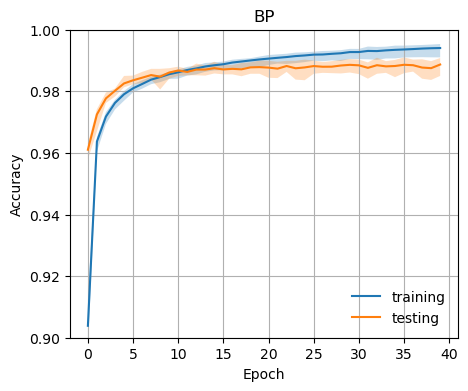

In [5]:
current_time_tmp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(f"{imul} end at {current_time_tmp}")

current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
if fsave: 
    save_dict = {
        "res": res
}
np.savez_compressed(res_path / f"res",  **save_dict)
    
testacctt = np.max(res[:,2,:], axis= -1)
trainacctt = np.max(res[:,1,:], axis= -1)
print(f'\t_'
    f"train: {np.mean(trainacctt) * 100:.2f}%+-{np.std(trainacctt, ddof=1)*100:.2f}% ({np.min(trainacctt) * 100:.2f}% {np.max(trainacctt) * 100:.2f}%)"
    f"\t test: {np.mean(testacctt) * 100:.2f}%+-{np.std(testacctt, ddof=1)*100:.2f}% ({np.min(testacctt) * 100:.2f}% {np.max(testacctt) * 100:.2f}%)\n")


plt.figure(figsize=(5, 4))
tt = res[:,1,:]
plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'training')  #  plot
plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
tt = res[:,2,:]
plt.plot(np.arange(len(np.mean(tt, axis=0))), np.mean(tt, axis=0), label=f'testing')  #  plot
plt.fill_between(np.arange(len(np.mean(tt, axis=0))), np.min(tt, axis=0), np.max(tt, axis=0), alpha=0.25)
if np.min(tt)<0.8:
    plt.ylim([0.0, 1.0])
    plt.yticks(np.arange(0.0,1.01,0.25))
else:
    plt.ylim([0.9, 1.0])
    plt.yticks(np.arange(0.9,1.01,0.02))
plt.grid()
plt.title(f"BP")
plt.xlabel(f'Epoch')
plt.ylabel('Accuracy')
plt.legend(frameon=False, fancybox=False, shadow=False)

current_time = time.strftime("%Y%m%d-%H%M%S", time.localtime())
print(f'Current Time: {current_time}')
plt.savefig(res_path /f"aEP_cnn_MNIST_maxacc{np.max(tt)}-{lr[0]:.4f}-{lr[1]:.4f}-{lr[2]:.4f}-{wd[0]:.2e}-{current_time}.svg", format="svg")
